# Plotting the Accerleration Mismatch

The following code generates Figure 11 (b)

In [1]:
import os
os.chdir(f'{os.getcwd()}/../../')
WORKING_DIR = './evaluation/uspc'

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
import torch
import pandas
import imageio
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
from datasets.xihe.loader import XiheTestDataset
from datasets.xihe.loader import XiheTrainD10Dataset
from model import XiheNet

from utils3d import fibonacci_sphere
from utils3d import cartesian_to_spherical

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(color_codes=True)

In [ ]:
def shc_recon(shc):
    # shc = torch.ones((3, 9))

    x = torch.unsqueeze(sphere_anchors[0, :], dim=0)
    y = torch.unsqueeze(sphere_anchors[1, :], dim=0)
    z = torch.unsqueeze(sphere_anchors[2, :], dim=0)

    recon = torch.zeros(
        3, (sphere_anchors.size()[1])).float()

    recon += torch.unsqueeze(shc[:, 0], dim=-1) * 0.886227

    recon += torch.unsqueeze(shc[:, 1], dim=-1) * 2.0 * 0.511664 * y
    recon += torch.unsqueeze(shc[:, 2], dim=-1) * 2.0 * 0.511664 * z
    recon += torch.unsqueeze(shc[:, 3], dim=-1) * 2.0 * 0.511664 * x

    recon += torch.unsqueeze(shc[:, 4], dim=-1) * 2.0 * 0.429043 * x * y
    recon += torch.unsqueeze(shc[:, 5], dim=-1) * 2.0 * 0.429043 * y * z
    recon += torch.unsqueeze(shc[:, 6], dim=-1) * 0.743125 * z * z - 0.247708
    recon += torch.unsqueeze(shc[:, 7], dim=-1) * 2.0 * 0.429043 * x * z
    recon += torch.unsqueeze(shc[:, 8], dim=-1) * 0.429043 * (x * x - y * y)

    return recon


def shc_recon_mse_loss(source, target):

    s = source.view((-1, 3, 9))
    t = target.view((-1, 3, 9))

    loss = torch.zeros(1).float()

    for i in range(len(s)):
        recon_source = shc_recon(s[i])
        recon_target = shc_recon(t[i])

        loss += F.mse_loss(recon_source, recon_target)

    loss = loss / len(s)

    return loss.to(source.device)

In [5]:
experiments = pd.read_csv(f'{WORKING_DIR}/../xihenet/data/experiments.csv')
def load_model(distribution, num_anchors):
    t = experiments[
        (experiments['distribution'] == distribution) & 
        (experiments['num_anchors'] == num_anchors)
    ]
    
    exp_name = t['exp_name'].values[0]
    ckpt_num = t['checkpoint_number'].values[0]
    
    model = PointARPlus.load_from_checkpoint(
        f'/home/yiqinzhao/Projects/experiments-archive' +
        f'/{exp_name}' +
        f'/model_dumps/{ckpt_num}.ckpt').cuda()
    model.eval()
    
    return model

In [6]:
df_res = pd.DataFrame(columns=['data_idx', 'n_anchors', 'grid_height', 'shc_rmse', 'ir_rmse'])

In [7]:
for n_anchors in [512, 768, 1024, 1280, 1536, 1792, 2048]:
    anchor_pos = fibonacci_sphere(n_anchors)
    model = load_model('sphere', n_anchors)
    n_min = torch.Tensor(model.hparams['min']).cuda()
    n_scale = torch.Tensor(model.hparams['scale']).cuda()
    dataset = XiheTestDataset(distribution='sphere', n_anchors=n_anchors)
        
    for i in tqdm(range(len(dataset))):
        x, y = dataset[i]

        _, x_xyz_world, x_rgb, _ = x
        x_xyz_world = torch.unsqueeze(x_xyz_world, 0).cuda()
        x_rgb = torch.unsqueeze(x_rgb, 0).cuda()
        y = torch.unsqueeze(y, 0).cuda()

        source = model.forward(x_xyz_world, x_rgb)
        target = y

        source_norm = (source - n_min) / n_scale

        shc_rmse = torch.sqrt(F.mse_loss(source_norm, target)).item()
        ir_rmse = torch.sqrt(shc_recon_mse_loss(source_norm.cpu(), target.cpu())).item()
        
        df_res.loc[len(df_res)] = [i, n_anchors, 0, shc_rmse, ir_rmse]
        
        
        for v_acc_grid in [256, 512, 768, 1024]:
        
            acc_grid = np.frombuffer(
                open(f'{WORKING_DIR}/data/grid_{n_anchors}_{v_acc_grid * 2}_{v_acc_grid}.bytes', 'rb').read(), 
                dtype=np.uint32
            ).reshape((v_acc_grid, -1))

            pc = np.load(f'/home/yiqinzhao/xihe-dataset/test/{i}/point_cloud.npy')
            pc -= np.array([0, 0.1, 0, 0, 0, 0, 0, 0, 0])
            pos = pc[:, :3]
            clr = pc[:, 3:6]
            dst = np.linalg.norm(pos, axis=-1)
            mask = dst > 0

            pos = pos[mask]
            dst = dst[mask]
            clr = clr[mask]

            p_rnd_sph = cartesian_to_spherical(pos)
            p_rnd_sph_theta = p_rnd_sph[:, 0]
            p_rnd_sph_phi = p_rnd_sph[:, 1]


            p_rnd_cu = np.round(np.degrees(p_rnd_sph_phi) % 360 / 360 * (v_acc_grid * 2 - 1)).astype(np.int)
            p_rnd_cv = np.round(np.degrees(p_rnd_sph_theta) / 180 * (v_acc_grid - 1)).astype(np.int)
            p_rnd_cuv = np.stack((p_rnd_cu, p_rnd_cv), axis=-1)


            p2a = acc_grid[p_rnd_cuv[:, 1], p_rnd_cuv[:, 0]]
            df = pd.DataFrame.from_dict({ 'anchor_idx': p2a, 'distance': dst })
            t = df.groupby('anchor_idx').agg({'distance': 'idxmin'})
            p_idx = t['distance'].values
            a_idx = t.index.values


            anchor_dst = np.zeros((n_anchors), dtype=np.float32)
            anchor_dst[a_idx] = dst[p_idx]
            colors = np.zeros((n_anchors, 3), dtype=np.float32)

            positions = anchor_pos * anchor_dst[:, np.newaxis]
            colors[a_idx] = clr[p_idx]



            # positions, colors
            positions = torch.from_numpy(positions.transpose())
            positions = torch.unsqueeze(positions, 0).cuda()
            colors = torch.from_numpy(colors.transpose())
            colors = torch.unsqueeze(colors, 0).cuda()
            
            source = model.forward(positions, colors)
            target = y

            source_norm = (source - n_min) / n_scale

            shc_rmse = torch.sqrt(F.mse_loss(source_norm, target)).item()
            ir_rmse = torch.sqrt(shc_recon_mse_loss(source_norm.cpu(), target.cpu())).item()

            df_res.loc[len(df_res)] = [i, n_anchors, v_acc_grid, shc_rmse, ir_rmse]

100%|██████████| 2037/2037 [27:30<00:00,  1.23it/s]


In [9]:
df_res.to_csv(f'{WORKING_DIR}/results/acc_estimation_accuracy.csv')

In [5]:
df_res = pd.read_csv(f'{WORKING_DIR}/results/acc_estimation_accuracy.csv', index_col=0)

In [6]:
t = df_res.groupby(['n_anchors', 'grid_height'], as_index=False).mean()

In [7]:
t

,n_anchors,grid_height,data_idx,shc_rmse,ir_rmse
0,512.0,0.0,1018.0,0.086597,0.160095
1,512.0,256.0,1018.0,0.086556,0.160002
2,512.0,512.0,1018.0,0.086557,0.159978
3,512.0,768.0,1018.0,0.086585,0.160063
4,512.0,1024.0,1018.0,0.086586,0.160089
5,768.0,0.0,1018.0,0.085974,0.158930
6,768.0,256.0,1018.0,0.085957,0.158896
7,768.0,512.0,1018.0,0.086000,0.158942
8,768.0,768.0,1018.0,0.086015,0.159014
9,768.0,1024.0,1018.0,0.086001,0.158980


In [8]:
df_fg = pd.DataFrame(columns=['n_anchors', 'grid_height', 'grid_size', 'normalized_shc_rmse', 'normalized_ir_rmse'])

In [9]:
for n_anchors in [512, 768, 1024, 1280, 1536, 1792, 2048]:
    for v_acc_grid in [256, 512, 768, 1024]:
        df_base = t.query(f'n_anchors == {n_anchors} & grid_height == 0')
        base_shc_rmse = df_base['shc_rmse'].values[0]
        base_ir_rmse = df_base['ir_rmse'].values[0]
        
        df_data = t.query(f'n_anchors == {n_anchors} & grid_height == {v_acc_grid}')
        n_shc_rmse = df_data['shc_rmse'].values[0] / base_shc_rmse
        n_ir_rmse = df_data['ir_rmse'].values[0] / base_ir_rmse
        
        df_fg.loc[len(df_fg)] = [n_anchors, v_acc_grid, f'{v_acc_grid * 2}x{v_acc_grid}', n_shc_rmse, n_ir_rmse]

In [10]:
df_fg

,n_anchors,grid_height,grid_size,normalized_shc_rmse,normalized_ir_rmse
0,512,256,512x256,0.999522,0.999419
1,512,512,1024x512,0.999529,0.999267
2,512,768,1536x768,0.999859,0.999802
3,512,1024,2048x1024,0.999871,0.999964
4,768,256,512x256,0.999808,0.999785
5,768,512,1024x512,1.000301,1.000074
6,768,768,1536x768,1.000483,1.000530
7,768,1024,2048x1024,1.000314,1.000314
8,1024,256,512x256,1.000501,1.000570
9,1024,512,1024x512,1.000001,0.999945


<ipython-input-15-b6178342edac>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(ax.get_yticks(), decimals=2), size=16)


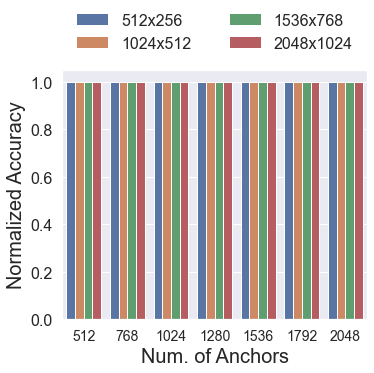

In [15]:
plt.figure(figsize=(5, 5))

ax = sns.barplot(data=df_fg, x='n_anchors', y='normalized_shc_rmse', hue='grid_size')
# num_locations = 7
# hatches = itertools.cycle(['/', '//'])
# for i, bar in enumerate(ax.patches):
#     if i % num_locations == 0:
#         hatch = next(hatches)
#     bar.set_hatch(hatch)

plt.legend(
    loc='lower center', fontsize=16, ncol=2,
    bbox_to_anchor=(0., 1.02, 1., .102), mode='expand',
    edgecolor=(0, 0, 0, 0),
    facecolor=(0, 0, 1, 0.0)
).get_frame().set_alpha(None)
ax.set_xlabel('Num. of Anchors', fontsize=20)
ax.set_ylabel('Normalized Accuracy', fontsize=20)
# plt.legend(title='Acc Grid Size', labels=['512x256', '1024x512', '1536x768', '2048x1024'])

# ax.set_ylim(0.5, 1.0)

ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.set_yticklabels(np.around(ax.get_yticks(), decimals=2), size=16)

plt.tight_layout(pad=0)
plt.savefig(f'{WORKING_DIR}/figures/acc_estimation_accuracy.pdf')  